# EOSC 213 — Lecture 5 Live Coding Notebook  
## Comparing Forward Euler vs Explicit Midpoint vs Backward Euler (Exponential Decay)

**Goal:** implement three time-stepping methods from scratch and compare:
- **Accuracy** vs step size `h`
- **When things go wrong** (oscillations / blow-up for Forward Euler)
- **Simple computational cost** using a **count of operations** (RHS evaluations + “solves”)

We study the same ODE:

$x'(t) = -\lambda x(t), \qquad x(0)=x_0,\quad \lambda>0.$

Exact solution:

$x(t)=x_0 e^{-\lambda t}.$


In [1]:
import torch
import matplotlib.pyplot as plt

# Make plots readable
plt.rcParams["figure.dpi"] = 130
torch.set_default_dtype(torch.float64)


## (1) Problem setup

We choose parameters so the dynamics are clear.  
We'll compare numerical solutions at the same final time `T` for several step sizes `h`.


In [ ]:
lam = 5.0     # lambda > 0
x0  = 1.0
t0  = 0.0
T   = 4.0

def exact_decay(t, x0=x0, lam=lam):
    return x0 * torch.exp(-lam * t)

t_fine = torch.linspace(t0, T, 2000)
x_fine = exact_decay(t_fine)
 

## (2) Three methods (implemented as functions)

### (A) Forward Euler  

$x_{n+1} = x_n + h(-\lambda x_n) = (1-\lambda h)x_n$

### (B) Explicit Midpoint (2nd order)

$x_{n+\frac12} = x_n + \frac{h}{2} f(t_n,x_n),\qquad
x_{n+1} = x_n + h f\!\left(t_n+\frac{h}{2},x_{n+\frac12}\right)$

### (C) Backward Euler  
$
x_{n+1} = x_n + h(-\lambda x_{n+1})
\Rightarrow (1+\lambda h)x_{n+1}=x_n
\Rightarrow x_{n+1} = \frac{1}{1+\lambda h}\,x_n
$

**Important:** For *this specific ODE*, Backward Euler has a closed-form update (no iteration needed).


In [6]:
def forward_euler(lam, x0, t0, T, h):
    N = int((T - t0) / h)
    t = t0 + h * torch.arange(N + 1)
    x = torch.zeros(N + 1); x[0] = x0
    # cost counters
    rhs_evals = 0
    for n in range(N):
        # f(t,x) = -lam*x
        rhs = -lam * x[n]; rhs_evals += 1
        x[n+1] = x[n] + h * rhs
    return t, x, {"rhs_evals": rhs_evals, "solves": 0, "steps": N}

def explicit_midpoint(lam, x0, t0, T, h):
    N = int((T - t0) / h)
    t = t0 + h * torch.arange(N + 1)
    x = torch.zeros(N + 1); x[0] = x0
    rhs_evals = 0
    for n in range(N):
        # f(t,x) = -lam*x
        k1 = -lam * x[n]; rhs_evals += 1
        x_half = x[n] + 0.5 * h * k1
        k2 = -lam * x_half; rhs_evals += 1
        x[n+1] = x[n] + h * k2
    return t, x, {"rhs_evals": rhs_evals, "solves": 0, "steps": N}

def backward_euler(lam, x0, t0, T, h):
    N = int((T - t0) / h)
    t = t0 + h * torch.arange(N + 1)
    x = torch.zeros(N + 1); x[0] = x0
    rhs_evals = 0  # (we don't evaluate f explicitly here)
    solves = 0
    denom = (1.0 + lam*h)
    for n in range(N):
        x[n+1] = x[n] / denom
        solves += 1
    return t, x, {"rhs_evals": rhs_evals, "solves": solves, "steps": N}


## (3) A quick “things can go wrong” demo (pick one bad step size)

Forward Euler’s factor is $(1-\lambda h)$.  
- If $(1-\lambda h) < 0$ ⇒ **sign flips** (oscillation)  
- If $|1-\lambda h| > 1$ ⇒ **blow-up** (grows instead of decays)

Try changing `h_bad` below.


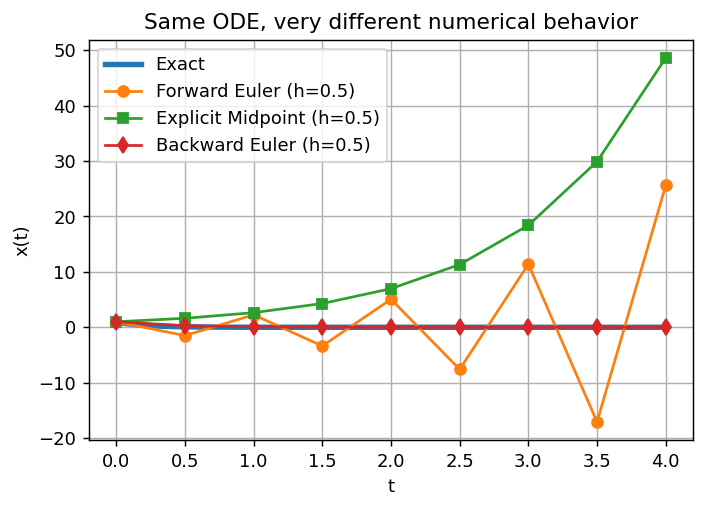

In [7]:
h_bad = 0.5   # with lam=5: (1-lam*h)=1-2.5=-1.5  => sign flips AND blow-up

t_fe, x_fe, _ = forward_euler(lam, x0, t0, T, h_bad)
t_mp, x_mp, _ = explicit_midpoint(lam, x0, t0, T, h_bad)
t_be, x_be, _ = backward_euler(lam, x0, t0, T, h_bad)

plt.figure(figsize=(6,4))
plt.plot(t_fine, x_fine, linewidth=3, label="Exact")
plt.plot(t_fe, x_fe, "o-", label=f"Forward Euler (h={h_bad})")
plt.plot(t_mp, x_mp, "s-", label=f"Explicit Midpoint (h={h_bad})")
plt.plot(t_be, x_be, "d-", label=f"Backward Euler (h={h_bad})")
plt.xlabel("t"); plt.ylabel("x(t)")
plt.title("Same ODE, very different numerical behavior")
plt.grid(True); plt.legend()
plt.show()


## (4) Systematic comparison across step sizes

We will:
1. Run each method for several `h`
2. Measure **error at final time**: $|x_N - x(T)|$
3. Measure simple **cost**:
   - `rhs_evals` = number of times we evaluated $f(t,x)$
   - `solves` = number of algebraic “solve steps” (Backward Euler has one per step here)

In [8]:
hs = torch.tensor([0.8, 0.4, 0.2, 0.1, 0.05], dtype=torch.float64)

methods = {
    "Forward Euler": forward_euler,
    "Explicit Midpoint": explicit_midpoint,
    "Backward Euler": backward_euler
}

results = {name: [] for name in methods}

for h in hs.tolist():
    xT_exact = exact_decay(torch.tensor(T)).item()
    for name, solver in methods.items():
        t_num, x_num, cost = solver(lam, x0, t0, T, h)
        err_T = abs(x_num[-1].item() - xT_exact)
        results[name].append({
            "h": h,
            "xT": x_num[-1].item(),
            "err_T": err_T,
            "rhs_evals": cost["rhs_evals"],
            "solves": cost["solves"],
            "steps": cost["steps"],
        })

results


{'Forward Euler': [{'h': 0.8,
   'xT': -243.0,
   'err_T': 243.00000000206114,
   'rhs_evals': 5,
   'solves': 0,
   'steps': 5},
  {'h': 0.4,
   'xT': 1.0,
   'err_T': 0.9999999979388464,
   'rhs_evals': 10,
   'solves': 0,
   'steps': 10},
  {'h': 0.2,
   'xT': 0.0,
   'err_T': 2.061153622438558e-09,
   'rhs_evals': 20,
   'solves': 0,
   'steps': 20},
  {'h': 0.1,
   'xT': 9.094947017729282e-13,
   'err_T': 2.060244127736785e-09,
   'rhs_evals': 40,
   'solves': 0,
   'steps': 40},
  {'h': 0.05,
   'xT': 1.0113490511326739e-10,
   'err_T': 1.9600187173252905e-09,
   'rhs_evals': 80,
   'solves': 0,
   'steps': 80}],
 'Explicit Midpoint': [{'h': 0.8,
   'xT': 3125.0,
   'err_T': 3124.9999999979386,
   'rhs_evals': 10,
   'solves': 0,
   'steps': 5},
  {'h': 0.4,
   'xT': 1.0,
   'err_T': 0.9999999979388464,
   'rhs_evals': 20,
   'solves': 0,
   'steps': 10},
  {'h': 0.2,
   'xT': 9.5367431640625e-07,
   'err_T': 9.516131627838115e-07,
   'rhs_evals': 40,
   'solves': 0,
   'steps': 

### Plot 1: Error vs step size (log-log)

You should see:
- Forward Euler ~ **1st order** (error drops ~ linearly with `h`)
- Explicit Midpoint ~ **2nd order** (error drops faster)
- Backward Euler ~ **1st order** (but stable for all `h`)


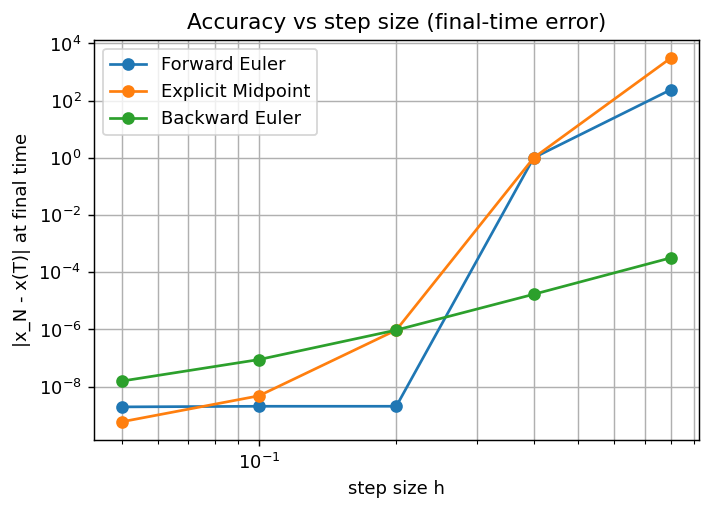

In [9]:
plt.figure(figsize=(6,4))
for name in methods:
    hs_list = [r["h"] for r in results[name]]
    errs    = [r["err_T"] for r in results[name]]
    plt.loglog(hs_list, errs, marker="o", label=name)

plt.xlabel("step size h")
plt.ylabel("|x_N - x(T)| at final time")
plt.title("Accuracy vs step size (final-time error)")
plt.grid(True, which="both")
plt.legend()
plt.show()


### Plot 2: Cost vs step size (how many operations did we do?)

We show a simple “cost”:
- `rhs_evals + solves`

In general nonlinear problems, Backward Euler may require **iterations** each step — that’s why implicit methods can be more expensive.


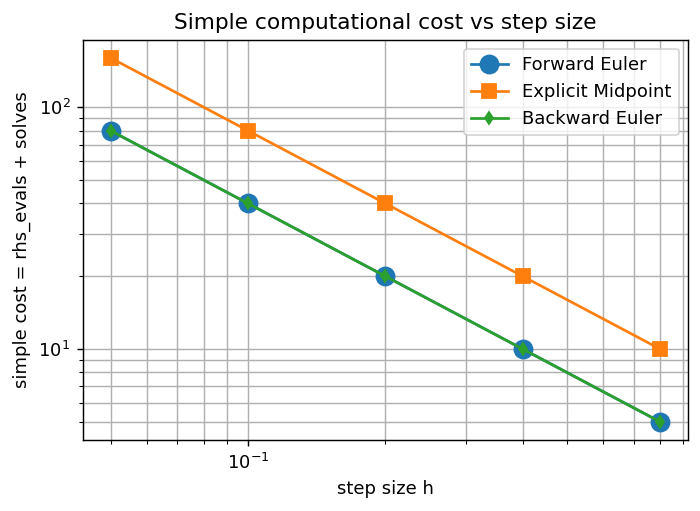

In [14]:
plt.figure(figsize=(6,4))
markers = ["o", "s", "d"]
markersizes = [10, 8, 5]
for name, marker, markersize in zip(methods, markers, markersizes):
    hs_list = [r["h"] for r in results[name]]
    rhs     = [r["rhs_evals"] for r in results[name]]
    solves  = [r["solves"] for r in results[name]]
    total_simple = [rhs_i + solves_i for rhs_i, solves_i in zip(rhs, solves)]
    plt.loglog(hs_list, total_simple, marker=marker, markersize=markersize, label=name)

plt.xlabel("step size h")
plt.ylabel("simple cost = rhs_evals + solves")
plt.title("Simple computational cost vs step size")
plt.grid(True, which="both")
plt.legend()
plt.show()


## (5) One figure: compare the three methods for *two different* step sizes

Pick:
- one “reasonable” `h_good`
- one “bad” `h_bad`

This is a good slide-worthy visualization.


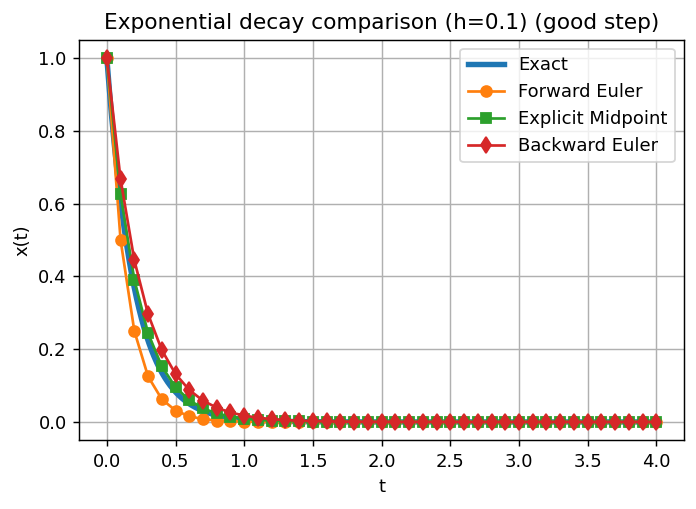

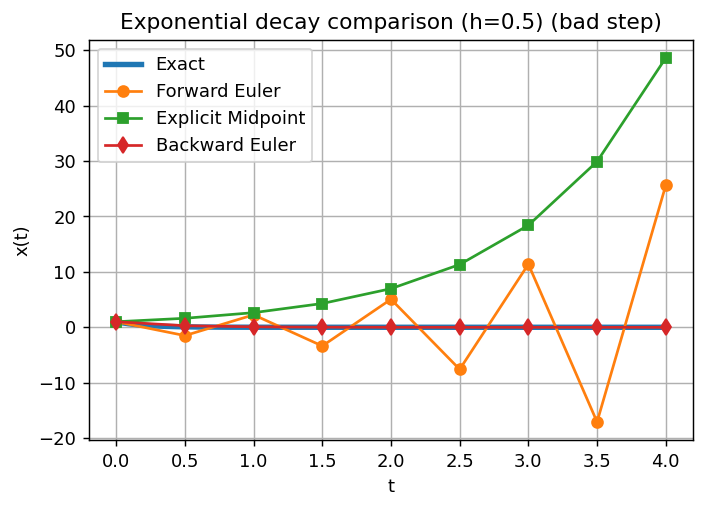

In [15]:
def compare_plot(h, title_suffix=""):
    t_fe, x_fe, _ = forward_euler(lam, x0, t0, T, h)
    t_mp, x_mp, _ = explicit_midpoint(lam, x0, t0, T, h)
    t_be, x_be, _ = backward_euler(lam, x0, t0, T, h)

    plt.figure(figsize=(6,4))
    plt.plot(t_fine, x_fine, linewidth=3, label="Exact")
    plt.plot(t_fe, x_fe, "o-", label="Forward Euler")
    plt.plot(t_mp, x_mp, "s-", label="Explicit Midpoint")
    plt.plot(t_be, x_be, "d-", label="Backward Euler")
    plt.xlabel("t"); plt.ylabel("x(t)")
    plt.title(f"Exponential decay comparison (h={h}) {title_suffix}")
    plt.grid(True); plt.legend()
    plt.show()

h_good = 0.1
h_bad  = 0.5

compare_plot(h_good, "(good step)")
compare_plot(h_bad, "(bad step)")


## In-class activity (5–10 minutes)

1. With `lam=5`, compute the Forward Euler factor \(1-\lambda h\) for:
   - `h = 0.1`, `0.3`, `0.5`
2. Predict: will the numerical solution **decay**, **oscillate**, or **blow up**?
3. Verify by running `compare_plot(h, ...)`.

**Bonus:** For the same `h`, why does Backward Euler still decay?
